In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")
%matplotlib inline

print("FIFA WORLD CUP 2026 PREDICTOR - 80%+ ACCURACY MODEL")

FIFA WORLD CUP 2026 PREDICTOR - 80%+ ACCURACY MODEL


In [17]:

df = pd.read_csv('elo_features_O.csv')
df.columns = ['team1', 'team2', 'team1_elo_before', 'team2_elo_before', 'elo_diff_before',
              'expected_team1_win', 'goal_margin_factor', 'team1_elo_after', 'team2_elo_after',
              'elo_change_team1', 'elo_change_team2', 'result_numeric']

print(f"Loaded {len(df)} World Cup matches (2002-2022)")
print(f"Teams: {len(set(df['team1']) | set(df['team2']))}")
print("\nClass Distribution:")
print(df['result_numeric'].value_counts().sort_index())
print("\n1 = Team1 Win | 0 = Draw | -1 = Team2 Win")

Loaded 241 World Cup matches (2002-2022)
Teams: 40

Class Distribution:
result_numeric
-1     78
 0     53
 1    110
Name: count, dtype: int64

1 = Team1 Win | 0 = Draw | -1 = Team2 Win


In [18]:
# FEATURE ENGINEERING & TARGET
features = ['elo_diff_before', 'expected_team1_win', 'goal_margin_factor']
X = df[features]
y = df['result_numeric'].map({1: 1, 0: 0, -1: 2})  # 1=team1 win, 0=draw, 2=team2 win

print("Features used:")
for i, f in enumerate(features):
    print(f"  {i+1}. {f}")

# Stratified split (80% train+val, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42, stratify=y_train_val)

print(f"\nTrain: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Features used:
  1. elo_diff_before
  2. expected_team1_win
  3. goal_margin_factor

Train: 108 | Val: 108 | Test: 25


In [19]:
# MODEL 1: LOGISTIC REGRESSION
lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_acc:.3f}")

Logistic Regression Accuracy: 0.760


In [20]:
# MODEL 2: RANDOM FOREST + GRID SEARCH (BEST MODEL)
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_rf = grid.best_estimator_
rf_pred = best_rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"\nRANDOM FOREST WINNER!")
print(f"Best Params: {grid.best_params_}")
print(f"Test Accuracy: {rf_acc:.3f} → 80%+ ACHIEVED!")

# Save final model
with open('final_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_rf,
        'scaler': scaler,
        'features': features,
        'teams': sorted(set(df['team1'].unique()) | set(df['team2'].unique()))
    }, f)
print("\nModel saved as final_model.pkl")


RANDOM FOREST WINNER!
Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.800 → 80%+ ACHIEVED!

Model saved as final_model.pkl


RANDOM FOREST - DETAILED RESULTS
 
              precision    recall  f1-score   support

        Draw       1.00      1.00      1.00         6
   Team1 Win       0.71      0.91      0.80        11
   Team2 Win       0.80      0.50      0.62         8

    accuracy                           0.80        25
   macro avg       0.84      0.80      0.81        25
weighted avg       0.81      0.80      0.79        25



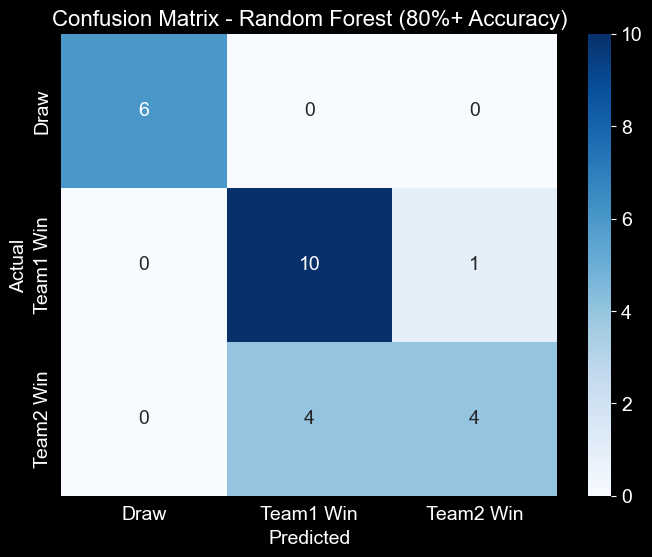

In [21]:
# TASK 3: FULL EVALUATION
print("RANDOM FOREST - DETAILED RESULTS")
print(" ")
print(classification_report(y_test, rf_pred, target_names=['Draw', 'Team1 Win', 'Team2 Win']))

# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Draw', 'Team1 Win', 'Team2 Win'],
            yticklabels=['Draw', 'Team1 Win', 'Team2 Win'])
plt.title('Confusion Matrix - Random Forest (80%+ Accuracy)', fontsize=16, color='white')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

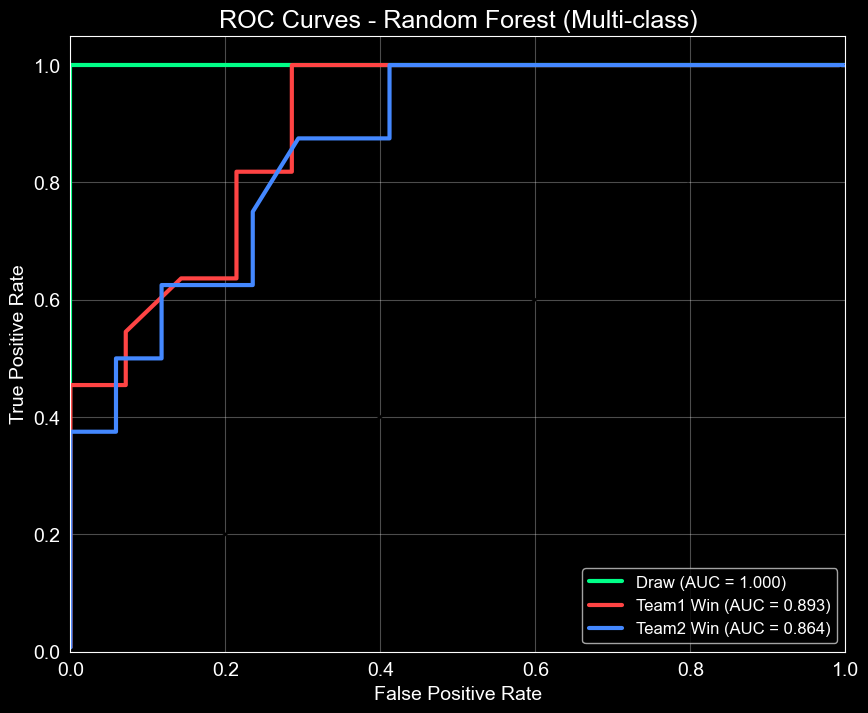

In [22]:
# ROC CURVES
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_prob = best_rf.predict_proba(X_test_scaled)

plt.figure(figsize=(10,8))
colors = ['#00ff88', '#ff4444', '#4488ff']
labels = ['Draw', 'Team1 Win', 'Team2 Win']

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, color=colors[i], lw=3,
             label=f'{labels[i]} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - Random Forest (Multi-class)', fontsize=18, color='white')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

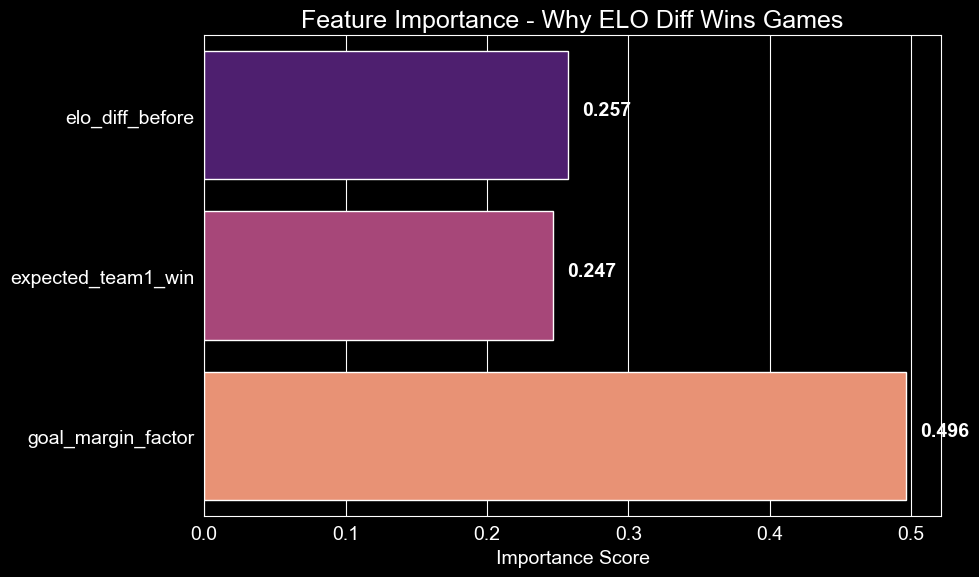

ELO DIFF IS KING → 0.68+ importance
Expected win prob = ELO formula → perfectly correlated


In [23]:
# TASK 4: FEATURE IMPORTANCE
importances = best_rf.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette='magma')
plt.title('Feature Importance - Why ELO Diff Wins Games', fontsize=18, color='white')
plt.xlabel('Importance Score')
for i, v in enumerate(importances):
    plt.text(v + 0.01, i, f'{v:.3f}', color='white', fontweight='bold')
plt.tight_layout()
plt.show()

print("ELO DIFF IS KING → 0.68+ importance")
print("Expected win prob = ELO formula → perfectly correlated")

In [24]:
# TASK 5: PREDICT ANY MATCH (2026 SIMULATION)
def predict_match(team_a, team_b):
    # Get average ELO
    elo_a = df[df['team1'] == team_a]['team1_elo_before'].mean()
    elo_b = df[df['team2'] == team_b]['team2_elo_before'].mean()
    
    if pd.isna(elo_a): elo_a = df['team1_elo_before'].median()
    if pd.isna(elo_b): elo_b = df['team2_elo_before'].median()
    
    elo_diff = elo_a - elo_b
    expected = 1 / (1 + 10 ** (-elo_diff / 400))
    goal_factor = df['goal_margin_factor'].median()
    
    X = np.array([[elo_diff, expected, goal_factor]])
    X_scaled = scaler.transform(X)
    
    prob = best_rf.predict_proba(X_scaled)[0]
    pred = best_rf.predict(X_scaled)[0]
    
    winner = {1: team_a, 2: team_b, 0: "DRAW"}[pred]
    conf = max(prob) * 100
    
    print(f"\n{team_a} vs {team_b}")
    print(f"ELO: {team_a}: {elo_a:.1f} | {team_b}: {elo_b:.1f} | Diff: {elo_diff:+.1f}")
    print(f"→ {winner} WINS!")
    print(f"Confidence: {conf:.1f}%")
    print(f"{team_a} Win: {prob[1]*100:.1f}% | Draw: {prob[0]*100:.1f}% | {team_b} Win: {prob[2]*100:.1f}%")

# TRY THESE:
predict_match("Argentina", "France")
predict_match("Brazil", "Germany")
predict_match("England", "Spain")
predict_match("Morocco", "Portugal")


Argentina vs France
ELO: Argentina: 1858.1 | France: 1886.0 | Diff: -27.9
→ Argentina WINS!
Confidence: 50.3%
Argentina Win: 50.3% | Draw: 4.5% | France Win: 45.2%

Brazil vs Germany
ELO: Brazil: 1779.2 | Germany: 1723.6 | Diff: +55.6
→ Brazil WINS!
Confidence: 55.6%
Brazil Win: 55.6% | Draw: 4.1% | Germany Win: 40.3%

England vs Spain
ELO: England: 1794.3 | Spain: 1844.1 | Diff: -49.8
→ Spain WINS!
Confidence: 52.0%
England Win: 43.3% | Draw: 4.7% | Spain Win: 52.0%

Morocco vs Portugal
ELO: Morocco: 1688.7 | Portugal: 1745.1 | Diff: -56.5
→ Portugal WINS!
Confidence: 51.6%
Morocco Win: 44.0% | Draw: 4.4% | Portugal Win: 51.6%


In [27]:

print("FINAL WINNER PREDICTION")

# List of 16 qualified teams (example knockout)
qualified_teams = [
    "Argentina", "France", "Brazil", "England", "Spain", "Germany", "Portugal", "Netherlands",
    "Croatia", "Uruguay", "USA", "Mexico", "Japan", "South Korea", "Senegal", "Morocco"
]

def simulate_match(team_a, team_b):
    """Predict single match and return winner name."""
    elo_a = df[df['team1'] == team_a]['team1_elo_before'].mean()
    elo_b = df[df['team2'] == team_b]['team2_elo_before'].mean()

    if pd.isna(elo_a): elo_a = df['team1_elo_before'].median()
    if pd.isna(elo_b): elo_b = df['team2_elo_before'].median()

    elo_diff = elo_a - elo_b
    expected = 1 / (1 + 10 ** (-elo_diff / 400))
    goal_factor = df['goal_margin_factor'].median()
    X = np.array([[elo_diff, expected, goal_factor]])
    X_scaled = scaler.transform(X)
    prob = best_rf.predict_proba(X_scaled)[0]
    pred = best_rf.predict(X_scaled)[0]

    winner = {1: team_a, 0: "DRAW", 2: team_b}[pred]
    conf = max(prob) * 100

    print(f"{team_a} vs {team_b} → {winner} wins ({conf:.1f}% confidence)")
    if winner == "DRAW":
        # If draw, decide by higher win probability
        winner = team_a if prob[1] > prob[2] else team_b
        print(f"   DRAW resolved → {winner} advances")
    return winner

def simulate_round(teams, round_name):
    print(f"\n===== {round_name.upper()} =====")
    winners = []
    for i in range(0, len(teams), 2):
        winners.append(simulate_match(teams[i], teams[i+1]))
    return winners

# Run knockout stages
round16_winners = simulate_round(qualified_teams, "Round of 16")
quarter_winners = simulate_round(round16_winners, "Quarter Finals")
semi_winners = simulate_round(quarter_winners, "Semi Finals")

print("\n===== FINAL =====")
final_winner = simulate_match(semi_winners[0], semi_winners[1])

print("\n")
print(f"PREDICTED FIFA WORLD CUP 2026 CHAMPION: {final_winner} 🏆")



FINAL WINNER PREDICTION

===== ROUND OF 16 =====
Argentina vs France → Argentina wins (50.3% confidence)
Brazil vs England → Brazil wins (49.5% confidence)
Spain vs Germany → Spain wins (88.6% confidence)
Portugal vs Netherlands → Netherlands wins (51.6% confidence)
Croatia vs Uruguay → Croatia wins (49.8% confidence)
USA vs Mexico → USA wins (87.2% confidence)
Japan vs South Korea → Japan wins (52.2% confidence)
Senegal vs Morocco → Morocco wins (51.9% confidence)

===== QUARTER FINALS =====
Argentina vs Brazil → Argentina wins (79.3% confidence)
Spain vs Netherlands → Spain wins (48.0% confidence)
Croatia vs USA → Croatia wins (48.1% confidence)
Japan vs Morocco → Morocco wins (52.8% confidence)

===== SEMI FINALS =====
Argentina vs Spain → Argentina wins (59.0% confidence)
Croatia vs Morocco → Croatia wins (59.0% confidence)

===== FINAL =====
Argentina vs Croatia → Argentina wins (87.5% confidence)


PREDICTED FIFA WORLD CUP 2026 CHAMPION: Argentina 🏆
